In [2]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy

print (sys.version)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


In [3]:
#setup
#tau: conformal time, a: scale factor, k: wavenumber (comoving)
#using natural units, hbar = c = 1, working in mpc

#constants
c = 3 * 1e8
h_0 = 0.7 
H_0 = h_0 * (1e5 / c) #maggiore, eq 17.5. units: mpc^-1

Omega_R = 4.184 * 1e-5 * (h_0 ** -2) #maggiore 17.79
Omega_M = 0.3 #maggiore 17.80
Omega_L = 1 - Omega_R - Omega_M #see section below maggiore 17.80
# Lambda = (1 / 3.24078) * 1e-6 #from wikipedia (converted), units: mpc^-2

#RD/MD equilibrium, maggiore values
a_eq = Omega_R / Omega_M #maggiore 17.83
tau_0 = 0.879 * 2 / (H_0 * math.sqrt(Omega_M))
tau_star = (2 * math.sqrt(Omega_R)) / (H_0 * Omega_M)
tau_eq = (math.sqrt(2) - 1) * tau_star
tau_dec = 2.55

k_eq = 0.073 * Omega_M * h_0**2 #from papers

#MD/lambdaD equilibrium (?)
a_eq2 = (Omega_M / Omega_L) ** (1/3)
print(H_0, tau_eq, tau_0)


0.0002333333333333333 109.35888364509906 13755.660801344031


In [4]:
#functions
def a_RD_deep(tau): #deep in RD, maggiore 17.130
    return H_0 * math.sqrt(Omega_R) * tau
def a_MD_deep(tau): #deep in MD, maggiore 17.143
    return (1 / 4) * (H_0 ** 2) * Omega_M * (tau ** 2)

#stitches above two functions, not great
def a_RDMD_deep(tau):
    if tau < tau_eq:
        return a_RD_deep(tau)
    else:
        return a_MD_deep(tau)

def a_RDMD(tau): #RD and MD, maggiore 17.152
    return a_eq * ((2 * tau / tau_star) + (tau / tau_star)**2 )

def a_RDMD_p(tau):
    return a_eq * ((2 / tau_star) + (2 * tau / (tau_star ** 2)))

def curly_H(tau):
    return a_RDMD_p(tau) / a_RDMD(tau)

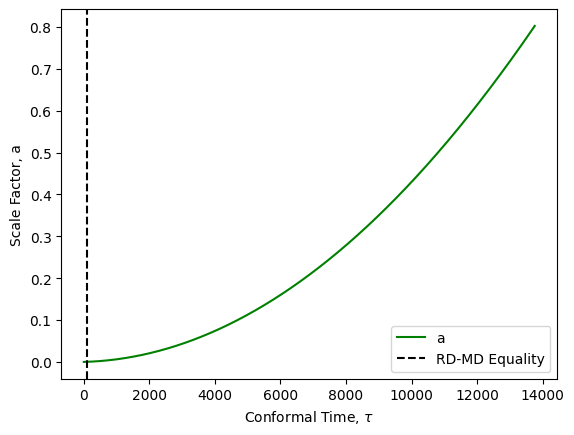

In [23]:
#plotting scale factor

tau_domain = np.linspace(1, tau_0, 10000)

a = (np.vectorize(a_RDMD))(tau_domain)
H = (np.vectorize(curly_H))(tau_domain)

#derivative test:
# a = np.vectorize(a_turner)(tau_domain)
# H_num = (np.gradient(a, tau_domain)) / (a)

plt.plot(tau_domain, a, c = "g", label = "a")
# plt.plot(tau_domain, H, c = "b")
plt.axvline(tau_eq, color = "black", linestyle = "dashed", label = "RD-MD Equality")
# plt.axvline(tau_0, color = "black", linestyle = "dashed")

plt.xlabel(r"Conformal Time, $\tau$")
plt.ylabel(r"Scale Factor, a")
plt.legend()


In [5]:
#horizon crossing calculations
# print("known:", tau_eq)

#use this!
def hc_H(k): #calc h.c. time for k using curlyH = k
    eq = lambda tau: curly_H(tau) - k
    return scipy.optimize.fsolve(eq, 0.001)[0]
def hc_H_inv(tau): #calc. k s.t. h.c. time for k is tau
    return curly_H(tau)

# def hc_tau(k): #calc h.c. time for k using k*tau = 1
#     return (1 / k)

k_try = k_eq

print(hc_H_inv(tau_eq), k_eq)


0.010713102001442336 0.010730999999999997


In [66]:
#calculating transfer function

def transfer_exp(choice, sc):
    def wrapper(k):
        bessel_part = (3 * scipy.special.spherical_jn(1, (k * sc) * tau_0) / ((k * sc) * tau_0))
        approx_part = math.sqrt(1 + 1.36*(k / k_eq) + 2.5*((k / k_eq)**2))
        if choice == 'full':
            return bessel_part * approx_part
        else:
            return bessel_part if choice == 'bessel' else approx_part
    return wrapper

def BTTS_fit(k):
    return math.sqrt(1 + 1.57*(k / k_eq) + 3.42*((k / k_eq)**2))

#helper for solve_ivp, specific to massless diff. eq.
def derivs(k): #pass in k to use
    def wrapper(tau, y):
        a = y[0]
        b = y[1]
        return [b, -2 * curly_H(tau) * b - a * (k**2)]
    return wrapper

def transfer_num(k):
    taus = np.linspace(0.1, tau_0, 2) #only need 2 points technically lol
    #derivs given above, y0 has 1 for init h_k and 0 for h_k'
    sols = scipy.integrate.solve_ivp(derivs(k), t_span = [taus[0], taus[-1]], y0 = [1, 0], t_eval = taus)
    return sols.y[0][-1] 

def omega(k, tau):
    return k / a_RDMD(tau)

def transfer_num_WKB(k):
    tau_k = hc_H(k)
    # eq = lambda tau: np.sqrt((omega(k, tau_k) * (a_RDMD(tau_k)**3)) / (omega(k, tau) * (a_RDMD(tau) ** 3))) 
    # eq = lambda tau: a_RDMD(tau_k) / a_RDMD(tau)
    # return 1 if (tau_k > tau_0) else eq(tau_0)
    return 1 if (tau_k > tau_0) else a_RDMD(tau_k)

#given k array and vals array, calculate mins and maxes
#return two arrays: one for ks, one of max/min vals
def extrema(ks, vals):
    k_e = []
    val_e = []
    lev = 10
    for i in range(lev, len(vals)-lev):
        if (vals[i] > vals[i-1] and vals[i] > vals[i+1] and vals[i] > vals[i-lev] and vals[i] > vals[i+lev] ) or \
           (vals[i] < vals[i-1] and vals[i] < vals[i+1] and vals[i] < vals[i-lev] and vals[i] < vals[i+lev]):
            k_e.append(ks[i])
            val_e.append(vals[i])
    return (k_e, val_e)

In [18]:
print(k_eq)

0.010730999999999997


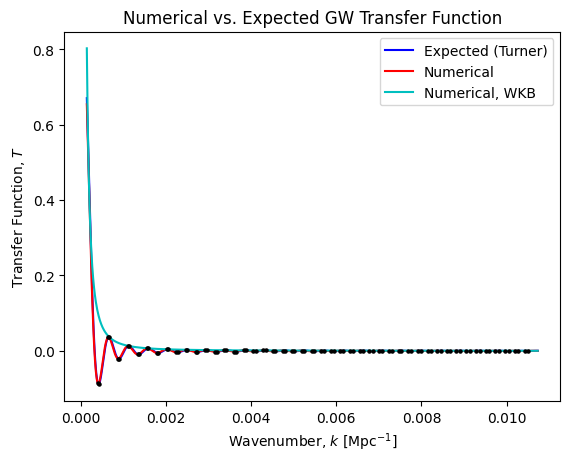

In [69]:
#plotting transfer function, numerical and expected

# k_dom = np.linspace(hc_H_inv(tau_0), k_eq, 1000) #full region of interest

#region selector
num_regions = 1
#choose: 1, ..., num_regions
curr_region = 1

region_size = (k_eq - hc_H_inv(tau_0)) / num_regions
start_k = hc_H_inv(tau_0) + (region_size * (curr_region - 1))
end_k = hc_H_inv(tau_0) + (region_size * (curr_region))

k_dom = np.linspace(start_k, end_k, 1000)

# k_dom = np.linspace(0.25, 0.5, 1000) #full region of interest


# scale = 1.011724778361694
scale = 1

#evaluation

#turner expected
tr_exp_b = (np.vectorize(transfer_exp("bessel", 1)))(k_dom)
tr_exp_nb = (np.vectorize(transfer_exp("no bessel", 1)))(k_dom)
tr_exp = (np.vectorize(transfer_exp("full", 1)))(k_dom)
# blue tilted tensor spectrum paper expected (no bessel)
tr_BTTS_fit = (np.vectorize(BTTS_fit))(k_dom)

#numerical
tr_num = (np.vectorize(transfer_num))(k_dom)
tr_num_wkb = (np.vectorize(transfer_num_WKB))(k_dom)


#calc and plot extrema points
(k_ext_num, tr_ext_num) = extrema(k_dom, tr_num)
plt.scatter(k_ext_num, tr_ext_num, c = "k", s = 5, zorder = 1)

(k_ext_exp, tr_ext_exp) = extrema(k_dom, tr_exp)
plt.scatter(k_ext_exp, tr_ext_exp, c = "k", s = 5, zorder = 1)

#plot transfer function curves
plt.plot(k_dom, tr_exp, c = "b", label = "Expected (Turner)", zorder = 0)
# plt.plot(k_dom, tr_exp_b, c = "g", label = "exp, bessel")
# plt.plot(k_dom, tr_exp_nb, c = "b", label = "exp, no bessel")
plt.plot(k_dom, tr_num, c = "r", label = "Numerical", zorder = 0)
plt.plot(k_dom, tr_num_wkb, c = "c", label = "Numerical, WKB", zorder = 0)

#turn these off for other ranges
# plt.axvline(k_eq, color = "black", linestyle = "dashed", label = r"$k_\mathrm{eq}$")
# plt.axvline(hc_H_inv(tau_0), color = "black", linestyle = "dotted", label = r"$k_0$")

plt.xlabel(r"Wavenumber, $k$ $[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"Transfer Function, $T$")
plt.title("Numerical vs. Expected GW Transfer Function")

plt.legend()

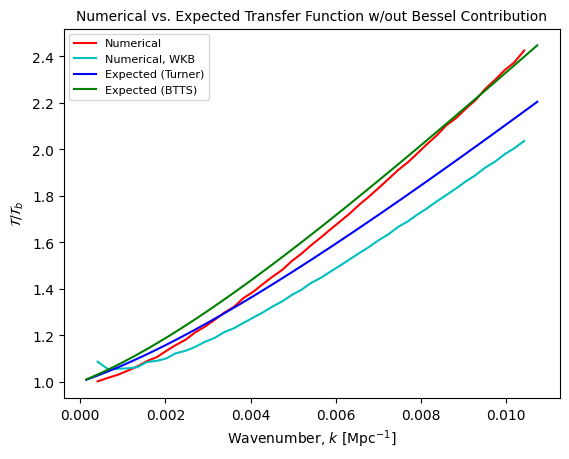

In [70]:
#take min in case there are false positives in extrema
min_len = min(len(tr_ext_num), len(tr_ext_exp))

tr_ext_num_nb = []
tr_ext_numWKB_nb = []
#divide out bessel part from tr_ext_num, point by point on extrema
for i in range(min_len):
    k_curr = k_ext_exp[i] #corr k value in exp
    bes = (3 * scipy.special.spherical_jn(1, (k_curr) * tau_0) / ((k_curr) * tau_0)) #bessel part
    # print(tr_ext_num[i], bes)
    tr_ext_num_nb.append(tr_ext_num[i] / bes)
    tr_ext_numWKB_nb.append(transfer_num_WKB(k_curr) / np.abs(bes))


    
# tr_ext_exp_nb = []
# #divide out bessel part from tr_ext_exp
# for i in range(min_len):
#     k_curr = k_ext_exp[i] #corr k value in exp
#     bes = (3 * scipy.special.spherical_jn(1, (k_curr) * tau_0) / ((k_curr) * tau_0)) #bessel part
#     tr_ext_exp_nb.append(tr_ext_exp[i] / bes)

#plot transfer function w/out bessel part
# plt.scatter(k_ext_num[:(min_len)], tr_ext_num_nb, c = "r", s = 5, zorder = 1, label = "num, nb")
plt.plot(k_ext_num[:(min_len)], tr_ext_num_nb, c = "r", zorder = 1, label = "Numerical")
plt.plot(k_ext_num[:(min_len)], tr_ext_numWKB_nb, c = "c", zorder = 1, label = "Numerical, WKB")
# plt.scatter(k_ext_exp, tr_ext_exp_nb, c = "b", s = 5, zorder = 1, label = "exp, no bessel")

plt.plot(k_dom, tr_exp_nb, c = "b", label = "Expected (Turner)")
plt.plot(k_dom, tr_BTTS_fit, c = "g", label = "Expected (BTTS)")

# #turn these off for other ranges
# plt.axvline(k_eq, color = "black", linestyle = "dashed", label = r"$k_\mathrm{eq}$")
# plt.axvline(hc_H_inv(tau_0), color = "black", linestyle = "dotted", label = r"$k_0$")

plt.xlabel(r"Wavenumber, $k$ $[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\mathcal{T} / \mathcal{T}_b$")
plt.title("Numerical vs. Expected Transfer Function w/out Bessel Contribution", fontsize = 10)


# plt.legend()
plt.legend(loc = 2, prop={'size': 8})